In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [2]:
import tensorflow as tf
from tensorflow import keras

%load_ext tensorboard

2023-11-01 13:31:49.247390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 13:31:49.401827: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 13:31:50.034388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-01 13:31:50.034486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
# we'll read both of these values and the original input and irrelevant tcrs
X_cdr3s = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
X_epitopes = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)
hit = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

In [4]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [5]:
# assemble hold out
df_ext_X_hit = hit.loc[hit['Epitope'] == 'GLCTLVAML']
df_ext_X_irr = irr.loc[irr['Epitope'] == 'GLCTLVAML']
df_ext_y = pd.concat([pd.Series(np.ones(df_ext_X_hit.shape[0]), index=df_ext_X_hit),
                      pd.Series(np.zeros(df_ext_X_irr.shape[0]), index=df_ext_X_irr)], axis=0)
df_ext_X = pd.concat([df_ext_X_hit, df_ext_X_irr], axis=0).reset_index().iloc[:, 1:]
df_ext_y = df_ext_y.reset_index().iloc[:, 1]

In [7]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# complete 10 iterations
for seed in range(10):
    # grab a subset
    np.random.seed(seed)
    perc_train = 0.75

    # training and during training testing
    mask_hit = ~(hit['CDR3'].isin(df_ext_X['CDR3']) | hit['Epitope'].isin(df_ext_X['Epitope']))
    mask_irr = ~(irr['CDR3'].isin(df_ext_X['CDR3']) | irr['Epitope'].isin(df_ext_X['Epitope']))
    # > subset target
    idxs = np.random.choice(hit[mask_hit].index, size=sum(mask_hit), replace=False)
    idxs, idys = idxs[:round(sum(mask_hit) * perc_train)], idxs[round(sum(mask_hit) * perc_train):]
    hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
    # > subset control
    idxs = np.random.choice(irr[mask_irr].index, size=sum(mask_irr), replace=False)
    idxs, idys = idxs[:round(sum(mask_irr) * perc_train)], idxs[round(sum(mask_irr) * perc_train):]
    irr_train, irr_test = irr.loc[idxs], irr.loc[idys]

    # create X for training
    X_train = pd.concat([hit_train, irr_train], axis=0).reset_index().iloc[:, 1:]
    cdr3s_training = X_train['CDR3'].unique()
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)
    # grab y for training
    y_train = pd.concat([pd.Series(np.ones(hit_train.shape[0])), pd.Series(np.zeros(irr_train.shape[0]))], axis=0).astype(int)
    y_train = y_train.reset_index().iloc[:, 1:][0]

    # create X for testing
    X_test = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]
    X_test_cdr3s = X_cdr3s.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
    X_test_epitopes = X_epitopes.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
    X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
    X_test = X_test_cdr3s.join(X_test_epitopes)
    # grab y for testing
    y_test = pd.concat([pd.Series(np.ones(hit_test.shape[0])), pd.Series(np.zeros(irr_test.shape[0]))], axis=0).astype(int)
    y_test = y_test.reset_index().iloc[:, 1:][0]

    # create X for validation
    X_val = df_ext_X.copy().reset_index().iloc[:, 1:]
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)
    # grab y for validation
    y_val = df_ext_y.copy().reset_index().iloc[:, 1:][0]
    
    print(X_train.shape[0], X_val.shape[0])

    # remove constant columns
    X_train = X_train.loc[:, X_train.nunique(0) > 1]
    X_train = X_train.loc[:, X_train.sum(0) > 0]
    # read in normalization factors
    means = X_train.mean(0)
    stds = (X_train - means).std(0)
    # subset for relevant columns
    X_train = X_train[means.index]
    X_test = X_test[means.index]
    X_val = X_val.T.reindex(means.index).fillna(0).T
    # normalize
    X_train -= means
    X_train /= stds
    X_test -= means
    X_test /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=1,
                        validation_data=([X_val[cols_cdr3], X_val[cols_ag]], y_val),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print(auc(fpr, tpr))

109785 21596


2023-11-01 10:10:58.425404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-01 10:10:58.425439: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-01 10:10:58.425836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


675/675 [==============================] - 1s 2ms/step
0.6695083674664601
109785 21596
675/675 [==============================] - 1s 2ms/step
0.670158392966202
109785 21596
675/675 [==============================] - 1s 2ms/step
0.6787914286000141
109785 21596
675/675 [==============================] - 1s 2ms/step
0.6565197775328402
109785 21596
675/675 [==============================] - 1s 2ms/step
0.6493678223873092
109785 21596
675/675 [==============================] - 2s 2ms/step
0.6778733391299068
109785 21596
675/675 [==============================] - 2s 2ms/step
0.6569492604301931
109785 21596
675/675 [==============================] - 2s 2ms/step
0.6640790543956279
109785 21596
675/675 [==============================] - 2s 2ms/step
0.6864843252268472
109785 21596
675/675 [==============================] - 2s 2ms/step
0.6806691302318645


[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

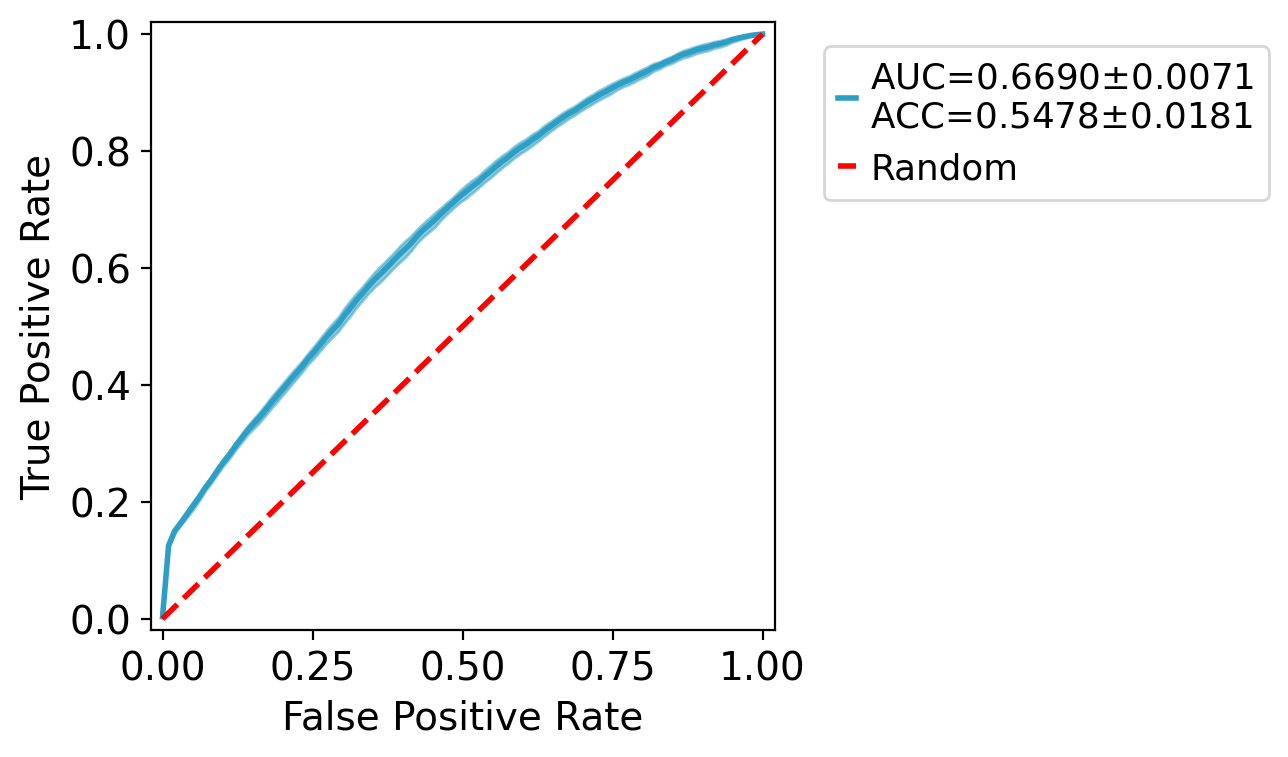

In [8]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

In [9]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [10]:
# assemble hold out
df_ext_X_hit = hit.loc[hit['Epitope'] == 'GLCTLVAML']
df_ext_X_irr = irr.loc[irr['Epitope'] == 'GLCTLVAML']
df_ext_y = pd.concat([pd.Series(np.ones(df_ext_X_hit.shape[0]), index=df_ext_X_hit),
                      pd.Series(np.zeros(df_ext_X_irr.shape[0]), index=df_ext_X_irr)], axis=0)
df_ext_X = pd.concat([df_ext_X_hit, df_ext_X_irr], axis=0).reset_index().iloc[:, 1:]
df_ext_y = df_ext_y.reset_index().iloc[:, 1]

In [11]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# complete 10 iterations
for seed in range(10):
    # grab a subset
    np.random.seed(seed)
    perc_train = 0.75

    # training and during training testing
    mask_hit = ~(hit['CDR3'].isin(df_ext_X['CDR3']) | hit['Epitope'].isin(df_ext_X['Epitope']))
    mask_irr = ~(irr['CDR3'].isin(df_ext_X['CDR3']) | irr['Epitope'].isin(df_ext_X['Epitope']))
    # > subset target
    idxs = np.random.choice(hit[mask_hit].index, size=sum(mask_hit), replace=False)
    idxs, idys = idxs[:round(sum(mask_hit) * perc_train)], idxs[round(sum(mask_hit) * perc_train):]
    hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
    # > subset control
    idxs = np.random.choice(irr[mask_irr].index, size=sum(mask_irr), replace=False)
    idxs, idys = idxs[:round(sum(mask_irr) * perc_train)], idxs[round(sum(mask_irr) * perc_train):]
    irr_train, irr_test = irr.loc[idxs], irr.loc[idys]

    # create X for training
    X_train = pd.concat([hit_train, irr_train], axis=0).reset_index().iloc[:, 1:]
    cdr3s_training = X_train['CDR3'].unique()
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)
    # grab y for training
    y_train = pd.concat([pd.Series(np.ones(hit_train.shape[0])), pd.Series(np.zeros(irr_train.shape[0]))], axis=0).astype(int)
    y_train = y_train.reset_index().iloc[:, 1:][0]

    # create X for testing
    X_test = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]
    X_test_cdr3s = X_cdr3s.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
    X_test_epitopes = X_epitopes.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
    X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
    X_test = X_test_cdr3s.join(X_test_epitopes)
    # grab y for testing
    y_test = pd.concat([pd.Series(np.ones(hit_test.shape[0])), pd.Series(np.zeros(irr_test.shape[0]))], axis=0).astype(int)
    y_test = y_test.reset_index().iloc[:, 1:][0]

    # create X for validation
    X_val = df_ext_X.copy().reset_index().iloc[:, 1:]
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)
    # grab y for validation
    y_val = df_ext_y.copy().reset_index().iloc[:, 1:][0]
    
    print(X_train.shape[0], X_val.shape[0])

    # remove constant columns
    X_train = X_train.loc[:, X_train.nunique(0) > 1]
    X_train = X_train.loc[:, X_train.sum(0) > 0]
    # read in normalization factors
    means = X_train.mean(0)
    stds = (X_train - means).std(0)
    # subset for relevant columns
    X_train = X_train[means.index]
    X_test = X_test[means.index]
    X_val = X_val.T.reindex(means.index).fillna(0).T
    # normalize
    X_train -= means
    X_train /= stds
    X_test -= means
    X_test /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=5,
                        validation_data=([X_val[cols_cdr3], X_val[cols_ag]], y_val),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print(auc(fpr, tpr))

109785 21596
Epoch 1/5
3431/3431 [==============================] - 14s 4ms/step - loss: 0.4902 - accuracy: 0.7686 - auc: 0.7816 - val_loss: 0.7567 - val_accuracy: 0.5546 - val_auc: 0.6667
Epoch 2/5
3431/3431 [==============================] - 13s 4ms/step - loss: 0.4386 - accuracy: 0.7948 - auc: 0.8340 - val_loss: 0.7330 - val_accuracy: 0.6018 - val_auc: 0.6847
Epoch 3/5
3431/3431 [==============================] - 14s 4ms/step - loss: 0.4002 - accuracy: 0.8170 - auc: 0.8676 - val_loss: 0.9743 - val_accuracy: 0.5666 - val_auc: 0.6692
Epoch 4/5
3431/3431 [==============================] - 13s 4ms/step - loss: 0.3548 - accuracy: 0.8434 - auc: 0.8995 - val_loss: 0.9714 - val_accuracy: 0.5845 - val_auc: 0.6710
Epoch 5/5
675/675 [==============================] - 1s 2ms/step
0.6704282604040428
109785 21596
Epoch 1/5
3431/3431 [==============================] - 15s 4ms/step - loss: 0.4915 - accuracy: 0.7676 - auc: 0.7806 - val_loss: 0.8036 - val_accuracy: 0.5349 - val_auc: 0.6776
Epoch 2/5


[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

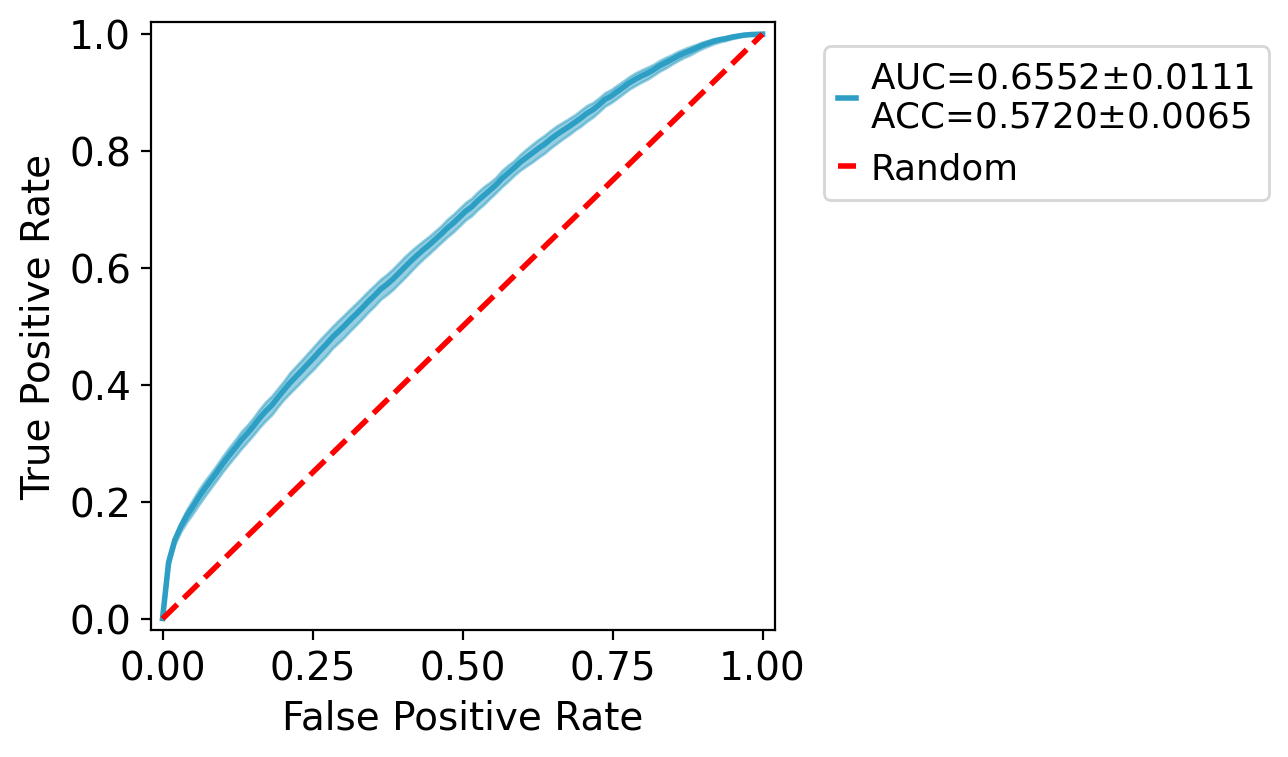

In [12]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

In [6]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [7]:
# assemble hold out
df_ext_X_hit = hit.loc[hit['Epitope'] == 'GLCTLVAML']
df_ext_X_irr = irr.loc[irr['Epitope'] == 'GLCTLVAML']
df_ext_y = pd.concat([pd.Series(np.ones(df_ext_X_hit.shape[0]), index=df_ext_X_hit),
                      pd.Series(np.zeros(df_ext_X_irr.shape[0]), index=df_ext_X_irr)], axis=0)
df_ext_X = pd.concat([df_ext_X_hit, df_ext_X_irr], axis=0).reset_index().iloc[:, 1:]
df_ext_y = df_ext_y.reset_index().iloc[:, 1]

In [8]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# complete 10 iterations
for seed in range(10):
    # grab a subset
    np.random.seed(seed)
    perc_train = 0.75

    # training and during training testing
    mask_hit = ~(hit['CDR3'].isin(df_ext_X['CDR3']) | hit['Epitope'].isin(df_ext_X['Epitope']))
    mask_irr = ~(irr['CDR3'].isin(df_ext_X['CDR3']) | irr['Epitope'].isin(df_ext_X['Epitope']))
    # > subset target
    idxs = np.random.choice(hit[mask_hit].index, size=sum(mask_hit), replace=False)
    idxs, idys = idxs[:round(sum(mask_hit) * perc_train)], idxs[round(sum(mask_hit) * perc_train):]
    hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
    # > subset control
    idxs = np.random.choice(irr[mask_irr].index, size=sum(mask_irr), replace=False)
    idxs, idys = idxs[:round(sum(mask_irr) * perc_train)], idxs[round(sum(mask_irr) * perc_train):]
    irr_train, irr_test = irr.loc[idxs], irr.loc[idys]

    # create X for training
    X_train = pd.concat([hit_train, irr_train], axis=0).reset_index().iloc[:, 1:]
    cdr3s_training = X_train['CDR3'].unique()
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)
    # grab y for training
    y_train = pd.concat([pd.Series(np.ones(hit_train.shape[0])), pd.Series(np.zeros(irr_train.shape[0]))], axis=0).astype(int)
    y_train = y_train.reset_index().iloc[:, 1:][0]

    # create X for testing
    X_test = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]
    X_test_cdr3s = X_cdr3s.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
    X_test_epitopes = X_epitopes.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
    X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
    X_test = X_test_cdr3s.join(X_test_epitopes)
    # grab y for testing
    y_test = pd.concat([pd.Series(np.ones(hit_test.shape[0])), pd.Series(np.zeros(irr_test.shape[0]))], axis=0).astype(int)
    y_test = y_test.reset_index().iloc[:, 1:][0]

    # create X for validation
    X_val = df_ext_X.copy().reset_index().iloc[:, 1:]
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)
    # grab y for validation
    y_val = df_ext_y.copy().reset_index().iloc[:, 1:][0]
    
    print(X_train.shape[0], X_val.shape[0])

    # remove constant columns
    X_train = X_train.loc[:, X_train.nunique(0) > 1]
    X_train = X_train.loc[:, X_train.sum(0) > 0]
    # read in normalization factors
    means = X_train.mean(0)
    stds = (X_train - means).std(0)
    # subset for relevant columns
    X_train = X_train[means.index]
    X_test = X_test[means.index]
    X_val = X_val.T.reindex(means.index).fillna(0).T
    # normalize
    X_train -= means
    X_train /= stds
    X_test -= means
    X_test /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_val[cols_cdr3], X_val[cols_ag]], y_val),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print(auc(fpr, tpr))

109785 21596


2023-11-01 13:32:03.874982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-01 13:32:03.875013: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-01 13:32:03.875394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
3431/3431 [==============================] - 14s 4ms/step - loss: 0.4909 - accuracy: 0.7686 - auc: 0.7809 - val_loss: 0.7513 - val_accuracy: 0.5676 - val_auc: 0.6688
Epoch 2/10
3431/3431 [==============================] - 13s 4ms/step - loss: 0.4378 - accuracy: 0.7953 - auc: 0.8350 - val_loss: 0.7219 - val_accuracy: 0.5943 - val_auc: 0.6586
Epoch 3/10
3431/3431 [==============================] - 14s 4ms/step - loss: 0.3988 - accuracy: 0.8178 - auc: 0.8686 - val_loss: 0.8472 - val_accuracy: 0.5841 - val_auc: 0.6547
Epoch 4/10
3431/3431 [==============================] - 14s 4ms/step - loss: 0.3512 - accuracy: 0.8450 - auc: 0.9013 - val_loss: 1.0277 - val_accuracy: 0.5877 - val_auc: 0.6467
Epoch 5/10
3431/3431 [==============================] - 13s 4ms/step - loss: 0.3022 - accuracy: 0.8700 - auc: 0.9288 - val_loss: 1.1476 - val_accuracy: 0.5904 - val_auc: 0.6455
Epoch 6/10
3431/3431 [==============================] - 13s 4ms/step - loss: 0.2575 - accuracy: 0.8912 - auc: 0.948

3431/3431 [==============================] - 14s 4ms/step - loss: 0.3026 - accuracy: 0.8699 - auc: 0.9283 - val_loss: 1.3326 - val_accuracy: 0.5656 - val_auc: 0.6562
Epoch 6/10
3431/3431 [==============================] - 13s 4ms/step - loss: 0.2592 - accuracy: 0.8901 - auc: 0.9479 - val_loss: 1.6294 - val_accuracy: 0.5553 - val_auc: 0.6345
Epoch 7/10
3431/3431 [==============================] - 13s 4ms/step - loss: 0.2229 - accuracy: 0.9068 - auc: 0.9617 - val_loss: 2.1726 - val_accuracy: 0.5565 - val_auc: 0.6360
Epoch 8/10
3431/3431 [==============================] - 14s 4ms/step - loss: 0.1943 - accuracy: 0.9205 - auc: 0.9709 - val_loss: 2.4506 - val_accuracy: 0.5506 - val_auc: 0.6010
Epoch 9/10
3431/3431 [==============================] - 14s 4ms/step - loss: 0.1712 - accuracy: 0.9303 - auc: 0.9775 - val_loss: 2.6473 - val_accuracy: 0.5545 - val_auc: 0.6097
Epoch 10/10
675/675 [==============================] - 2s 2ms/step
0.6499067800543883
109785 21596
Epoch 1/10
3431/3431 [=====

3431/3431 [==============================] - 14s 4ms/step - loss: 0.1671 - accuracy: 0.9317 - auc: 0.9786 - val_loss: 2.5086 - val_accuracy: 0.5512 - val_auc: 0.5933
Epoch 10/10
675/675 [==============================] - 1s 2ms/step
0.6102523905498132
109785 21596
Epoch 1/10
3431/3431 [==============================] - 15s 4ms/step - loss: 0.4934 - accuracy: 0.7661 - auc: 0.7778 - val_loss: 0.8095 - val_accuracy: 0.5289 - val_auc: 0.6588
Epoch 2/10
3431/3431 [==============================] - 14s 4ms/step - loss: 0.4398 - accuracy: 0.7947 - auc: 0.8331 - val_loss: 0.9070 - val_accuracy: 0.5594 - val_auc: 0.6770
Epoch 3/10
3431/3431 [==============================] - 13s 4ms/step - loss: 0.4004 - accuracy: 0.8168 - auc: 0.8672 - val_loss: 1.0473 - val_accuracy: 0.5539 - val_auc: 0.6629
Epoch 4/10
3431/3431 [==============================] - 13s 4ms/step - loss: 0.3502 - accuracy: 0.8459 - auc: 0.9017 - val_loss: 0.9936 - val_accuracy: 0.5757 - val_auc: 0.6537
Epoch 5/10
3431/3431 [=====

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

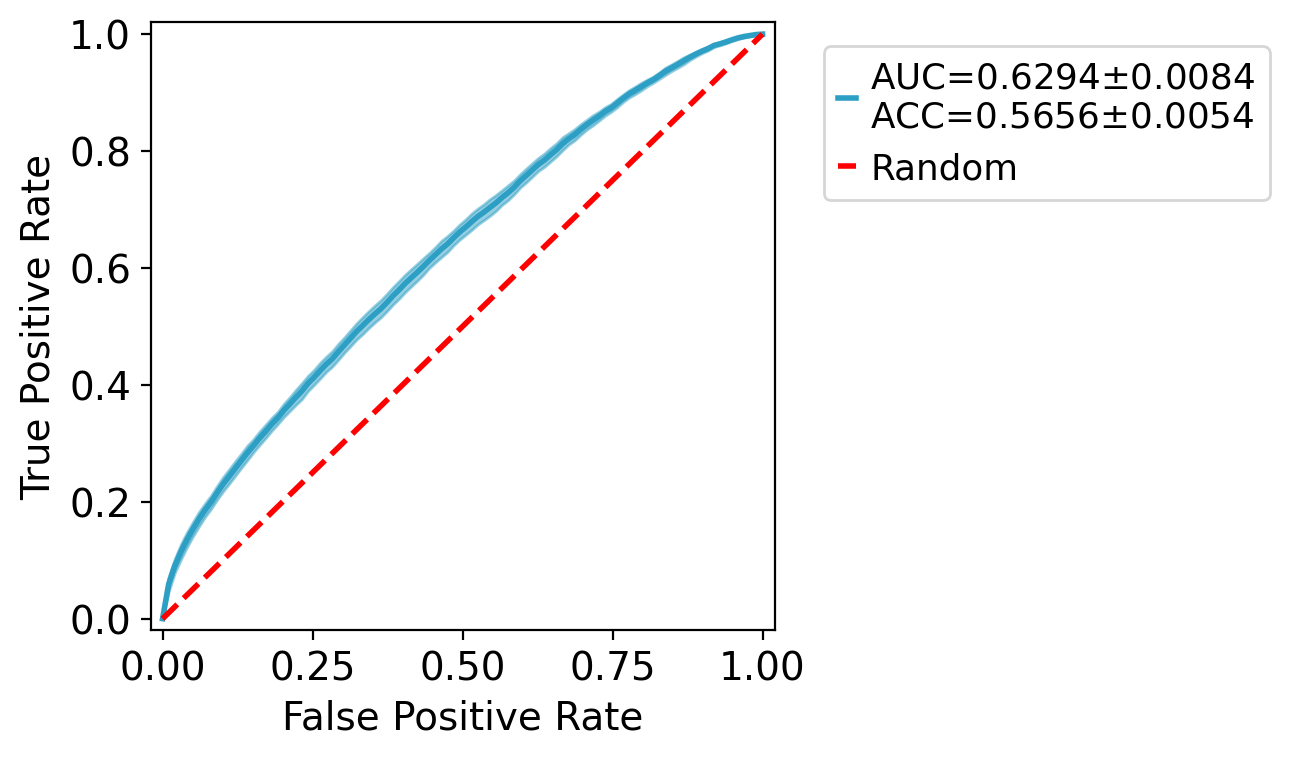

In [9]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')